![github](https://i.pinimg.com/originals/40/3d/82/403d82187a52ed098e306a51e76652fe.png)


### Houston, we have a problem...

We don't know what programming languages are in our repositories!  Today's mission is simple:   scrape data from NASA GitHub repository README files to build a model that can predict what programming language a repository is, given the text of the README file.

### Mission Plan

* acquire the data by scraping repositories github.com/NASA
* clean and prep the readme contents
* explore features with word clouds
* model the data
* evaluate the models

### Imports

In [1]:
import acquire as a
import wrangle as w
import explore as e
import model as m
#import model as m
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import re
import unicodedata
import nltk
from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.style as style 
style.available
style.use('seaborn-talk') #sets the size of the charts
style.use('seaborn-colorblind') #sets color of charts

### Acquire

<div class="alert alert-block alert-info">
<b>Acquire Takeaways:</b>
<br>- Acquiring this data was no walk on the moon...but luckily, this is where web scraping came in handy.  The functions used to acquire this data are located in the wrangle.py module. Requests and BeautifulSoup imports were used to acquire the data from github.  
<br>-  The requests import was used to make the http request and turn the response into a beautiful soup object.
<br>- Once the object was made, a loop was made to pull the titles of the repositories from github.  
<br>- After all repositories were pulled, Zach's function (scrape_github_data) was used to pull the repo, language, and readme contents.  
<br>- From there I turned the data into a pandas dataframe from a csv file after converting it froma json file.    
</div> 

In [2]:
#acquire the data
df = w.get_nasa()
df.head(10)

,repo,language,readme_contents
0,nasa/cumulus,JavaScript,# Cumulus Framework\n\n[![npm version](https:/...
1,nasa/openmct,JavaScript,# Open MCT [![license](https://img.shields.io/...
2,nasa/astrobee_android,Java,# Astrobee Robot Software - Android submodule\...
3,nasa/astrobee,C++,# Astrobee Robot Software\n\n### About\n\n<p>\...
4,nasa/earthdata-search,JavaScript,# [Earthdata Search](https://search.earthdata....
5,nasa/daa-displays,TypeScript,# DAA-Displays: A Toolkit for the Analysis of ...
6,nasa/code-nasa-gov,CSS,# CODE.NASA.GOV\n\n[![Build Status](https://tr...
7,nasa/cumulus-orca,Python,## Clone and build Operational Recovery Cloud ...
8,nasa/dorado-scheduling,Python,# Dorado observation planning and scheduling s...
9,nasa/cFS,CMake,[![Build Status](https://travis-ci.com/nasa/cF...


In [3]:
#shape of the dataset
df.shape

(291, 3)

In [4]:
#columns and data type summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             291 non-null    object
 1   language         275 non-null    object
 2   readme_contents  283 non-null    object
dtypes: object(3)
memory usage: 6.9+ KB


In [5]:
#check out nulls in dataset
df.isna().sum()

repo                0
language           16
readme_contents     8
dtype: int64

In [6]:
#check out the percentage of each programming language
df.language.value_counts(normalize=True) * 100

Python              24.363636
C                   16.727273
C++                 13.454545
JavaScript           7.636364
HTML                 4.727273
Java                 4.727273
Jupyter Notebook     4.363636
MATLAB               3.272727
Fortran              2.181818
Ruby                 1.818182
CSS                  1.818182
Shell                1.454545
IDL                  1.090909
R                    1.090909
Perl                 1.090909
PHP                  1.090909
TypeScript           1.090909
HCL                  0.727273
CMake                0.727273
Matlab               0.727273
Haskell              0.363636
Clojure              0.363636
Common Lisp          0.363636
SCSS                 0.363636
Emacs Lisp           0.363636
C#                   0.363636
Julia                0.363636
Prolog               0.363636
TeX                  0.363636
Limbo                0.363636
GLSL                 0.363636
Mathematica          0.363636
FORTRAN              0.363636
PLSQL     

[]

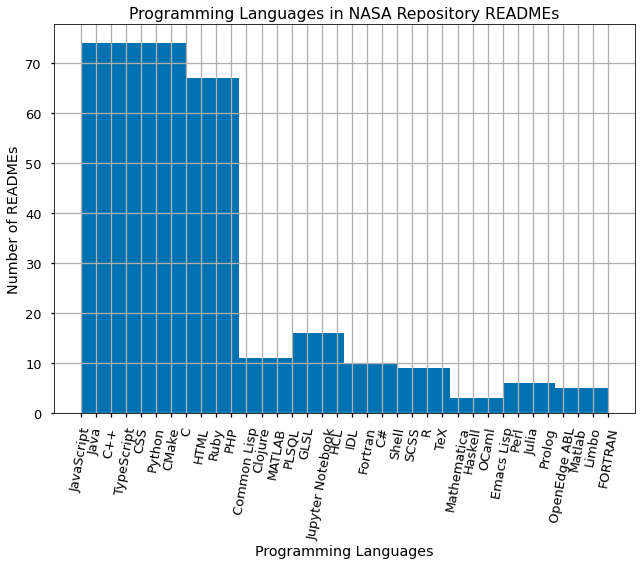

In [7]:
#histogram of different programming languages used
df.language.hist()
plt.title('Programming Languages in NASA Repository READMEs')
plt.xlabel('Programming Languages')
plt.ylabel('Number of READMEs')
plt.xticks(rotation = 80)
plt.plot()

### Prep

<div class="alert alert-block alert-info">
<b>Prepare Takeaways:</b>
<br>- The functions used to clean the data are located in the wrangle.py module.  
<br>-  The original form of the readme contents contained non-ASCII characters, special characters, etc that would make it difficult to parse.   
<br>- The function used to clean the readme contents converted all text to lowercase, remoced accented characters, removed special characters, lemmatized the words, and removed stopwords. 
<br>- There were a few missing values upon inspection and these nulls were dropped.    
</div> 

In [8]:
#drop null values
df.dropna(inplace=True)

In [9]:
#ensure nulls dropped
df.isna().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [10]:
#columns and data type summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 0 to 290
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             270 non-null    object
 1   language         270 non-null    object
 2   readme_contents  270 non-null    object
dtypes: object(3)
memory usage: 8.4+ KB


In [11]:
#clean the data
df.readme_contents = df.readme_contents.apply(w.clean)
df.head()

,repo,language,readme_contents
0,nasa/cumulus,JavaScript,cumulus framework npm versionhttpsbadgefuryioj...
1,nasa/openmct,JavaScript,open mct licensehttpsimgshieldsiobadgelicensea...
2,nasa/astrobee_android,Java,astrobee robot software android submodule astr...
3,nasa/astrobee,C++,astrobee robot software p img srcdocimagesastr...
4,nasa/earthdata-search,JavaScript,earthdata searchhttpssearchearthdatanasagov se...


### Explore

In [12]:
#look at readmes by language
df.language.value_counts()[:10]

Python              66
C                   46
C++                 37
JavaScript          21
HTML                13
Java                13
Jupyter Notebook    11
MATLAB               9
Fortran              6
Ruby                 5
Name: language, dtype: int64

In [13]:
#look at absolute value counts and percentage value counts
e.show_counts_and_ratios(df, "language")

,n,percent
Python,66,0.244444
C,46,0.170370
C++,37,0.137037
JavaScript,21,0.077778
HTML,13,0.048148
Java,13,0.048148
Jupyter Notebook,11,0.040741
MATLAB,9,0.033333
Fortran,6,0.022222
Ruby,5,0.018519


In [14]:
#top 5 language split
df.language.value_counts()[:5]

Python        66
C             46
C++           37
JavaScript    21
HTML          13
Name: language, dtype: int64

In [15]:
#break up data into top 5 languages

python_words = (' '.join(df[df.language == 'Python'].readme_contents)).split()
c_words = (' '.join(df[df.language == 'C'].readme_contents)).split()
c_plus_plus_words = (' '.join(df[df.language == 'C++'].readme_contents)).split()
java_script_words = (' '.join(df[df.language == 'JavaScript'].readme_contents)).split()
html_words = (' '.join(df[df.language == 'HTML'].readme_contents)).split()
all_words = (' '.join(df.readme_contents)).split()    

In [16]:
# Once we have a list of words, we can transform it into a pandas Series, 
# which we can then use to show us how often each of the words occurs.
python_freq = pd.Series(python_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus_words).value_counts()
java_script_freq = pd.Series(java_script_words).value_counts()
html_freq = pd.Series(html_words).value_counts()
all_freq = pd.Series(all_words).value_counts()


In [17]:
#Now we'll combine these three together to get one resulting data frame that we can work with:
word_counts = (pd.concat([all_freq, python_freq, c_freq, c_plus_plus_freq, java_script_freq, html_freq], axis=1, sort=True)
                .set_axis(['all', 'python', 'c', 'c++', 'java script', 'html'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,python,c,c++,java script,html
0,128,38,25,7,8,0
00,9,3,0,2,0,0
000,7,0,0,0,0,0
0000,6,0,0,0,0,0
00000,8,0,0,0,0,0


In [18]:
#sort by most frequent
word_counts.sort_values(by='all', ascending=False).head(10)

,all,python,c,c++,java script,html
file,1224,533,146,196,56,23
software,928,193,163,215,21,43
data,807,381,118,66,33,6
use,798,227,145,139,50,21
run,703,214,39,69,143,6
build,681,89,348,113,62,1
test,617,247,147,29,57,1
see,610,115,294,54,32,11
system,549,79,206,71,14,31
directory,528,184,43,75,26,10


In [19]:
#rename c++ and java script to get rid of plus and space
word_counts.rename(columns={'c++': 'cplusplus', 'java script': 'java_script'}, inplace=True)

Text(0, 0.5, 'Top 10 Words')

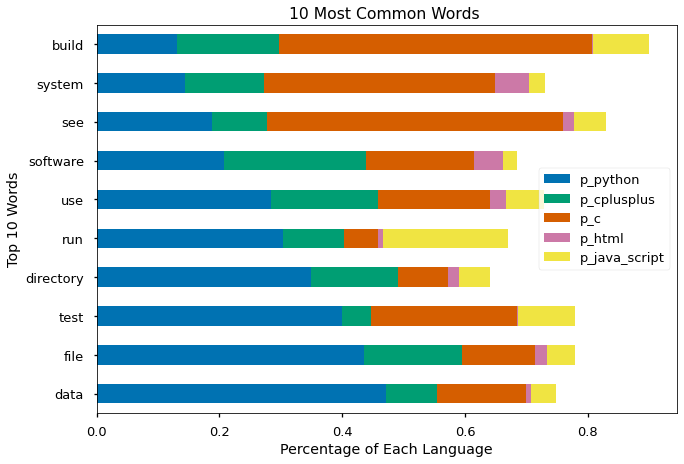

In [20]:
#figure out the percentage of each language vs each other
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_cplusplus=word_counts.cplusplus / word_counts['all'],
         p_c =word_counts.c / word_counts['all'],
         p_html=word_counts.html / word_counts['all'],
         p_java_script=word_counts.java_script / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_cplusplus', 'p_c', 'p_html', 'p_java_script']]
 .tail(10)
 .sort_values('p_python', ascending=False)
 .plot.barh(stacked=True))

plt.title('10 Most Common Words ')
plt.xlabel('Percentage of Each Language')
plt.ylabel('Top 10 Words')

#### Lets look at top 3 languages used

In [21]:
#top 10 python words
python_freq[:10]

file        533
data        381
python      323
test        247
use         227
run         214
image       207
using       196
software    193
install     191
dtype: int64

In [22]:
#top 10 C
c_freq[:10]


build          348
see            294
development    248
application    213
system         206
bundle         203
add            163
software       163
cf             163
test           147
dtype: int64

In [23]:
#top 10 C++
c_plus_plus_freq[:10]

software     215
file         196
message      142
use          139
api          127
build        113
library      104
subject       99
recipient     96
warranty      94
dtype: int64

In [62]:
#top 10 all words
all_freq[:10]

file         1224
software      928
data          807
use           798
run           703
build         681
test          617
see           610
system        549
directory     528
dtype: int64

#### Make some bigrams and word clouds of top 3

In [24]:
#make python bigrams
python_bigrams = (pd.Series(nltk.ngrams(python_words, 2)).value_counts().head(10))
print('Python Bigrams:')
print(python_bigrams)

Python Bigrams:
(subject, software)    91
(pip, install)         63
(united, state)        61
(et, al)               53
(state, government)    52
(warranty, subject)    39
(prior, recipient)     39
(use, subject)         39
(command, line)        33
(test, script)         30
dtype: int64


(-0.5, 399.5, 999.5, -0.5)

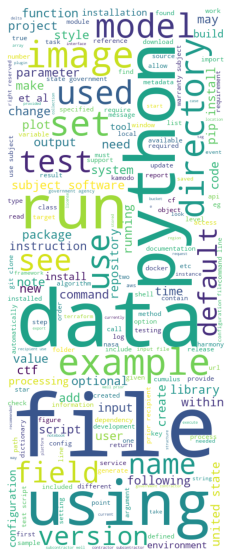

In [25]:
#word cloud for python words
python_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(python_words))
plt.figure(figsize=(15, 10))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(python_cloud)
# axis aren't very useful for a word cloud
plt.axis('off')

In [26]:
#make c bigrams
c_bigrams = (pd.Series(nltk.ngrams(c_words, 2)).value_counts().head(10))
print('C Bigrams:')
print(c_bigrams)

C Bigrams:
(development, build)    234
(core, flight)          101
(flight, system)         76
(update, see)            59
(minor, update)          56
(unit, test)             53
(storage, service)       44
(subject, software)      35
(open, source)           29
(operating, system)      28
dtype: int64


(-0.5, 399.5, 999.5, -0.5)

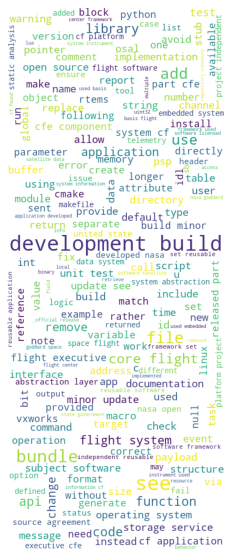

In [27]:
#word cloud for c words
c_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(c_words))
plt.figure(figsize=(15, 10))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(c_cloud)
# axis aren't very useful for a word cloud
plt.axis('off')

In [28]:
#make c++ bigrams
plus_bigrams = (pd.Series(nltk.ngrams(c_plus_plus_words, 2)).value_counts().head(10))
print('C++ Bigrams:')
print(plus_bigrams)

C++ Bigrams:
(subject, software)      88
(gmsec, api)             50
(united, state)          47
(state, government)      41
(warranty, subject)      38
(prior, recipient)       36
(use, subject)           36
(open, source)           24
(subcontractor, well)    24
(government, agency)     24
dtype: int64


(-0.5, 399.5, 999.5, -0.5)

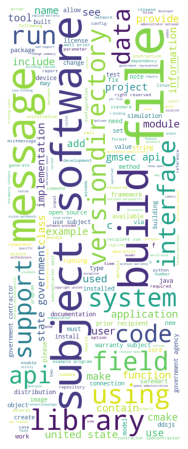

In [29]:
#word cloud for c++ words
plus_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(c_plus_plus_words))
plt.figure(figsize=(8, 8))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(plus_cloud)
# axis aren't very useful for a word cloud
plt.axis('off')

In [61]:
#bigrams for allwords
all_bigrams = (pd.Series(nltk.ngrams(all_words, 2)).value_counts().head(10))
print('All Words Bigrams:')
print(all_bigrams)

All Words Bigrams:
(subject, software)     354
(development, build)    257
(united, state)         215
(state, government)     188
(warranty, subject)     151
(use, subject)          150
(prior, recipient)      150
(open, source)          122
(core, flight)          113
(government, agency)    102
dtype: int64


(-0.5, 899.5, 292.5, -0.5)

<Figure size 576x576 with 0 Axes>

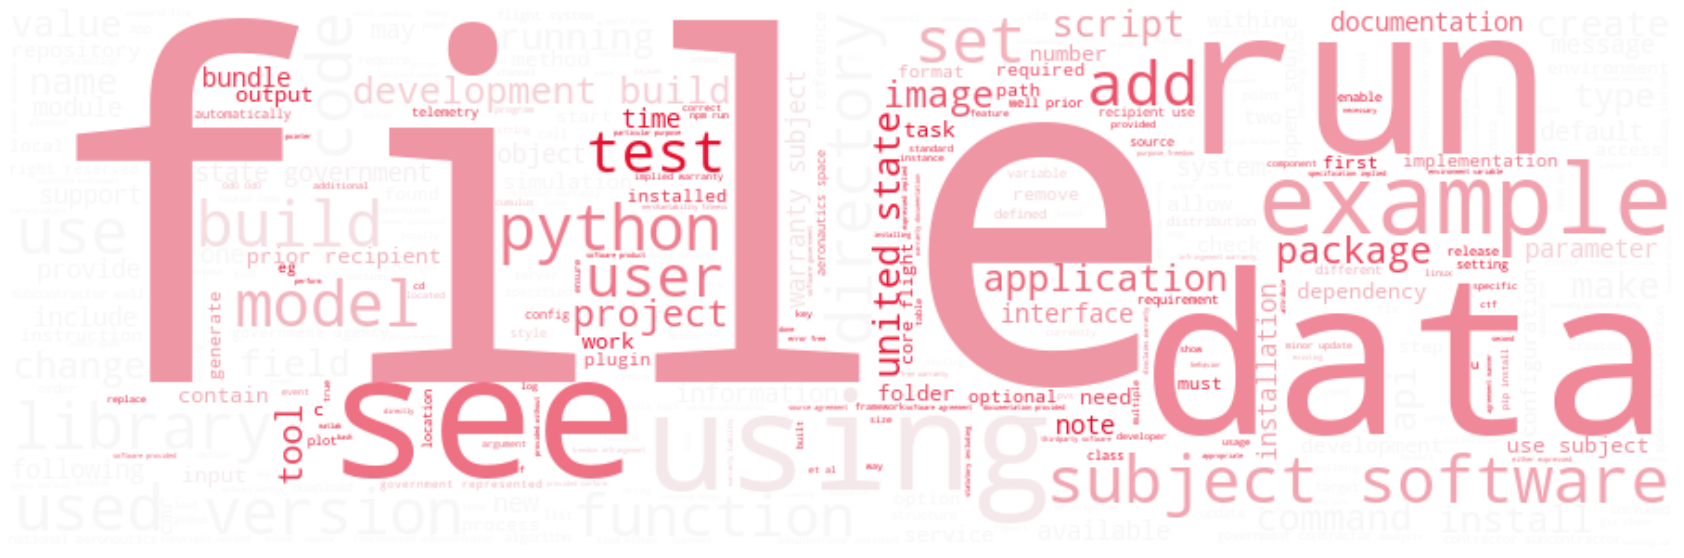

In [30]:
#word cloud for all words
mask1 = np.array(Image.open("nasalogo.jpg"))
wc1 = WordCloud(mask=mask1, background_color='white',
               max_words=2000, max_font_size=256,
               random_state=123)
wc1.generate(' '.join(all_words))
image_colors1 = ImageColorGenerator(mask1)
plt.figure(figsize=(8, 8))
# WordCloud() produces an image object, which can be displayed with plt.imshow
#plt.imshow(all_cloud)


fig, axes = plt.subplots(figsize=(30, 10))

plt.imshow(wc1.recolor(color_func=image_colors1), interpolation="bilinear")

# axis aren't very useful for a word cloud
plt.axis('off')

<div class="alert alert-block alert-info">
<b>Explore Takeaways:</b>
<br>- A total of 35 different programming languages detected.   
<br>- Top 5 languages detected are Python, C, C++, JavaScript, and Java. 
<br>- All three share the word file, so next iteration look into adding it to stop words.
<br>- They all have unique bigrams.  
</div> 

### Model

In [31]:
#check out data before modeling
df.head()

,repo,language,readme_contents
0,nasa/cumulus,JavaScript,cumulus framework npm versionhttpsbadgefuryioj...
1,nasa/openmct,JavaScript,open mct licensehttpsimgshieldsiobadgelicensea...
2,nasa/astrobee_android,Java,astrobee robot software android submodule astr...
3,nasa/astrobee,C++,astrobee robot software p img srcdocimagesastr...
4,nasa/earthdata-search,JavaScript,earthdata searchhttpssearchearthdatanasagov se...


In [32]:
#let get top 10 languages to model on
top_10_lang = df.language.value_counts().index[0:10]


In [33]:
#check out top 10 languages
top_10_lang

Index(['Python', 'C', 'C++', 'JavaScript', 'HTML', 'Java', 'Jupyter Notebook',
       'MATLAB', 'Fortran', 'Ruby'],
      dtype='object')

In [34]:
#create df with only top 10 languages
top_10 = df[df.language.isin(top_10_lang)]


#### Time to split into train, validate, test

In [35]:
#Split the data and stratify by language
train, validate, test = m.split(top_10, 'language')
train.shape

(126, 3)

In [36]:
# Setup our X variables
X_train = train.readme_contents
X_validate = validate.readme_contents
X_test = test.readme_contents

# Setup our y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

#### Create the baseline

In [37]:
#baseline
train.language.value_counts()[:3]

Python    37
C         26
C++       20
Name: language, dtype: int64

In [38]:
#baseline accuracy will be python
baseline = round((train.language == 'Python').mean(), 4) *100

print(f'The baseline accuracy is: {baseline} %')


The baseline accuracy is: 29.37 %


#### Logistic Regression

In [39]:
#make the thing
tfidf = TfidfVectorizer()

#fit the thing
tfidf.fit(X_train)

#use the thing
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

In [40]:
#make the model
lm = LogisticRegression()

#fit on vectorized
lm.fit(X_train_vectorized, y_train)

#make df for each split
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#make predictions with model
train['predicted'] = lm.predict(X_train_vectorized)
validate["predicted"] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

#in sample performance
print(classification_report(train.actual, train.predicted, zero_division=0))

                  precision    recall  f1-score   support

               C       0.96      0.92      0.94        26
             C++       0.76      0.95      0.84        20
         Fortran       0.00      0.00      0.00         3
            HTML       0.00      0.00      0.00         7
            Java       0.00      0.00      0.00         7
      JavaScript       1.00      0.75      0.86        12
Jupyter Notebook       0.00      0.00      0.00         6
          MATLAB       0.00      0.00      0.00         5
          Python       0.52      0.95      0.67        37
            Ruby       0.00      0.00      0.00         3

        accuracy                           0.69       126
       macro avg       0.32      0.36      0.33       126
    weighted avg       0.57      0.69      0.61       126



In [41]:
#out of sample performance
print(classification_report(validate.actual, validate.predicted,zero_division=0 ))

                  precision    recall  f1-score   support

               C       0.75      0.82      0.78        11
             C++       0.29      0.22      0.25         9
         Fortran       0.00      0.00      0.00         2
            HTML       0.00      0.00      0.00         3
            Java       0.00      0.00      0.00         3
      JavaScript       0.50      0.20      0.29         5
Jupyter Notebook       0.00      0.00      0.00         3
          MATLAB       0.00      0.00      0.00         2
          Python       0.38      0.81      0.52        16
            Ruby       0.00      0.00      0.00         1

        accuracy                           0.45        55
       macro avg       0.19      0.21      0.18        55
    weighted avg       0.35      0.45      0.37        55



#### Decision Tree

In [42]:
#make the thing
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
#fit the thing
clf = clf.fit(X_train_vectorized, y_train)
#predicitons
y_pred = clf.predict(X_train_vectorized)
#probability
y_pred_proba = clf.predict_proba(X_train_vectorized)

In [43]:
#make the dfs
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#make predictions
train['predicted'] = clf.predict(X_train_vectorized)
validate["predicted"] = clf.predict(X_validate_vectorized)
test['predicted'] = clf.predict(X_test_vectorized)

In [44]:
#in sample
print(classification_report(train.actual, train.predicted, zero_division=0))

                  precision    recall  f1-score   support

               C       1.00      0.58      0.73        26
             C++       0.30      0.95      0.45        20
         Fortran       0.00      0.00      0.00         3
            HTML       0.00      0.00      0.00         7
            Java       0.00      0.00      0.00         7
      JavaScript       1.00      0.58      0.74        12
Jupyter Notebook       1.00      0.67      0.80         6
          MATLAB       0.00      0.00      0.00         5
          Python       0.83      0.81      0.82        37
            Ruby       0.00      0.00      0.00         3

        accuracy                           0.60       126
       macro avg       0.41      0.36      0.35       126
    weighted avg       0.64      0.60      0.57       126



In [45]:
#out of sample
print(classification_report(validate.actual, validate.predicted,zero_division=0 ))

                  precision    recall  f1-score   support

               C       1.00      0.91      0.95        11
             C++       0.25      0.78      0.38         9
         Fortran       0.00      0.00      0.00         2
            HTML       0.00      0.00      0.00         3
            Java       0.00      0.00      0.00         3
      JavaScript       0.75      0.60      0.67         5
Jupyter Notebook       1.00      0.67      0.80         3
          MATLAB       0.00      0.00      0.00         2
          Python       0.73      0.50      0.59        16
            Ruby       0.00      0.00      0.00         1

        accuracy                           0.55        55
       macro avg       0.37      0.35      0.34        55
    weighted avg       0.58      0.55      0.53        55



#### KNN

In [46]:
#make the thing
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
#fit the thing
knn.fit(X_train_vectorized, y_train)
#use the thing
#predicts
y_pred = knn.predict(X_train_vectorized)
#probs
y_pred_proba = knn.predict_proba(X_train_vectorized)

In [47]:
#in sample
print(classification_report(train.actual, train.predicted, zero_division=0))

                  precision    recall  f1-score   support

               C       1.00      0.58      0.73        26
             C++       0.30      0.95      0.45        20
         Fortran       0.00      0.00      0.00         3
            HTML       0.00      0.00      0.00         7
            Java       0.00      0.00      0.00         7
      JavaScript       1.00      0.58      0.74        12
Jupyter Notebook       1.00      0.67      0.80         6
          MATLAB       0.00      0.00      0.00         5
          Python       0.83      0.81      0.82        37
            Ruby       0.00      0.00      0.00         3

        accuracy                           0.60       126
       macro avg       0.41      0.36      0.35       126
    weighted avg       0.64      0.60      0.57       126



In [48]:
#out of sample
print(classification_report(validate.actual, validate.predicted, zero_division=0))

                  precision    recall  f1-score   support

               C       1.00      0.91      0.95        11
             C++       0.25      0.78      0.38         9
         Fortran       0.00      0.00      0.00         2
            HTML       0.00      0.00      0.00         3
            Java       0.00      0.00      0.00         3
      JavaScript       0.75      0.60      0.67         5
Jupyter Notebook       1.00      0.67      0.80         3
          MATLAB       0.00      0.00      0.00         2
          Python       0.73      0.50      0.59        16
            Ruby       0.00      0.00      0.00         1

        accuracy                           0.55        55
       macro avg       0.37      0.35      0.34        55
    weighted avg       0.58      0.55      0.53        55



#### Random Forest

In [49]:
#make the thing
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)
#fit the thing
rf.fit(X_train_vectorized, y_train)
#use the thing
y_pred = rf.predict(X_train_vectorized)
#estimate probability
y_pred_proba = rf.predict_proba(X_train_vectorized)


In [50]:
#compute the accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train_vectorized, y_train)))

Accuracy of random forest classifier on training set: 0.51


In [51]:
print(classification_report(y_train, y_pred,  zero_division=0))

                  precision    recall  f1-score   support

               C       1.00      0.69      0.82        26
             C++       0.75      0.45      0.56        20
         Fortran       0.00      0.00      0.00         3
            HTML       0.00      0.00      0.00         7
            Java       0.00      0.00      0.00         7
      JavaScript       0.00      0.00      0.00        12
Jupyter Notebook       0.00      0.00      0.00         6
          MATLAB       0.00      0.00      0.00         5
          Python       0.39      1.00      0.56        37
            Ruby       0.00      0.00      0.00         3

        accuracy                           0.51       126
       macro avg       0.21      0.21      0.19       126
    weighted avg       0.44      0.51      0.42       126



## Test on Best

In [52]:
#make the thing
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
#fit the thing
clf = clf.fit(X_train_vectorized, y_train)
#makepreds
y_pred = clf.predict(X_train_vectorized)
#probas
y_pred_proba = clf.predict_proba(X_train_vectorized)
#make dfs
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [53]:
#predictions
train['predicted'] = clf.predict(X_train_vectorized)
validate["predicted"] = clf.predict(X_validate_vectorized)
test['predicted'] = clf.predict(X_test_vectorized)

In [54]:
#final test
print(classification_report(test.actual, test.predicted,zero_division=0 ))

                  precision    recall  f1-score   support

               C       1.00      0.67      0.80         9
             C++       0.26      0.75      0.39         8
         Fortran       0.00      0.00      0.00         1
            HTML       0.00      0.00      0.00         3
            Java       0.00      0.00      0.00         3
      JavaScript       1.00      0.75      0.86         4
Jupyter Notebook       0.33      0.50      0.40         2
          MATLAB       0.00      0.00      0.00         2
          Python       0.73      0.62      0.67        13
            Ruby       0.00      0.00      0.00         1

        accuracy                           0.52        46
       macro avg       0.33      0.33      0.31        46
    weighted avg       0.55      0.52      0.50        46



<div class="alert alert-block alert-info">
<b>Model Takeaways:</b>
<br>- Baseline Accuracy: 29%     
<br>- Logistic Regression Accuracy: 45%
<br>- Decision Tree Accuracy:  55%
<br>- KNN Accuracy: 55% 
<br>- Random Forest:  51%  
<br>- DT final model performed with 52% accuracy.    
</div> 

### Cool now lets predict some languages from the archived READMEs not included in the dataset

In [55]:
#import the archived repos from nasa
df = pd.read_csv('nasa_archived.csv')
df.head()

,Unnamed: 0,repo,language,readme_contents
0,0,nasa/nasawds-site,HTML,This repo is no longer maintained. Documentati...
1,1,nasa/nasawds-old,JavaScript,"This repo is no longer maintained, it is repla..."
2,2,nasa/data.nasa.gov,CSS,DATA.NASA.GOV\n=================\nTHIS IS OUT ...
3,3,nasa/cumulus-integration-tests,JavaScript,# Cumulus Integration Test Project [DEPRECATE...
4,4,nasa/cumulus-docs,JavaScript,# Cumulus Documentation\n\n**Note:** This Repo...


In [56]:
#drop unnamed
archived = df.drop(columns='Unnamed: 0')

In [57]:
#predict language of archived repos
archived.language[4]

'JavaScript'

In [59]:
def predict_repo_language(string):
    """
    This function will take in a NASA Github repo README
    and predict the programming language used.  Before predicting
    this function will clean readme contents, then turn 
    readme contents into a series so it can be transformed
    and predicted.
    """
    #clean the string
    clean_readme = w.clean(string)
    #turn string into series
    archived_series = pd.Series([clean_readme])
    #transform
    archived_series = tfidf.transform(archived_series)
    #print the language
    print('The language predicted is: ', clf.predict(archived_series))

In [60]:
predict_repo_language(archived.readme_contents[4])

The language predicted is:  ['JavaScript']


### Conclusion

<div class="alert alert-block alert-info">
<b>Conclusion:</b>
<br>- The model that performed the best was the Decision Tree model with an accuracy of 52%    
<br>- More data is needed to create a more accurate model.  
    
</div> 